# Mounting google drive

In [2]:
from google.colab import drive
DRIVE_PATH = '/content/drive'
drive.mount(DRIVE_PATH)

Mounted at /content/drive


# Libraries Installation

In [3]:
!pip install pyclustering

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.6 MB 7.2 MB/s 
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395122 sha256=045dc115b30cde7a3a090c98a2f82558deb23b0ca8f295b7186d6f7549a2406f
  Stored in directory: /root/.cache/pip/wheels/ea/87/6b/1e0568b5ba9dc6518a25338bae90bd8392f35206bb90bb10f1
Successfully built pyclustering


# Libraries Import

In [4]:
import warnings

# Basic libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler

# Encoder
from sklearn.preprocessing import LabelEncoder

# Cluster model
from sklearn.cluster import KMeans, DBSCAN
from pyclustering.cluster.clarans import clarans
from sklearn.mixture import GaussianMixture

# Evaluation
from sklearn.metrics import silhouette_score

# Tuning Classes


> TuningModel - A Basic(Parent) class for hyperparameter tuning

*   Public Methods:

 **Constructor(param)**
  - @param **param** - dictionary: parameters for tuning

 **fit(x)**
 
 - @param **x** - np.ndarray: Dataframe values for modeling

* Protected Methods

 **_model_execute(x, params)**
  - @param **x** - np.ndarray: dataframe values
  - @param **params** - dictionary: chosen parameters in whole parameter

 **_model_scoring(model, x)**
  - @param **model** - Any: Data model built in *_model_execute*
  - @param **x** - numpy.ndarray: dataframe values

*   Members

 *params*

 - parameter input from constructor

 *model_list*

 - model list, availiable after using **fit**

 *best_params_*

 - best model's parameters, availiable after using **fit**

 *best_score_*

 - best model's score, availiable after using **fit**

 *best_model_*

 - best model, availiable after using **fit**


In [5]:
class TuningModel:
    def __init__(self, param: dict):
        self.params = param
        self.model_list = []

        self.best_params_ = None
        self.best_score_ = None
        self.best_model_ = None

    def _model_execute(self, x, params):
        pass

    def _model_scoring(self, model, x):
        pass

    def fit(self, x):
        if self.params is None:
            raise Exception('Invalid parameters input: None', 'ParameterError')

        # Traversal for whole indices with digits
        # By computing the digits of each index
        #
        # Examples:
        #
        # Consider three digits (4, 2, 2) - in specific (quadratic, binary, binary)
        # We can get series of numbers:
        # 0 0 0 = 0(10)
        # 0 0 1 = 1
        # 0 1 0 = 2
        # ...
        # 3 0 0 = 12
        # 3 0 1 = 13
        # 3 1 0 = 14
        # 3 1 1 = 15
        #
        # In this case - we can explain the result number as
        # 15 = 3 * (2 * 2) + 1 * (2) + 1
        #
        # Similarly, we can apply them in traversal
        # length = 15 -> get indices (3, 1, 1) for clarans - {'n_cluster', 'num_local', 'max_neighbor'}
        # By using this, we visit whole parameters.

        length = 1
        param_keys = []

        # 1. Calc the total multiple of length, and the individual length
        for key, value in self.params.items():
            length *= len(value)
            param_keys.append(key)

        if length == 0:
            raise Exception('Invalid parameters input: No parameters input', 'ParameterError')

        # 2. Loop until the length became 0
        while length > 0:
            params = {}

            temp = length - 1
            for i, key in enumerate(param_keys):
                # 2-1. Calculate the total multiple of the lower digits
                remain = 1
                for next_key in param_keys[i + 1:]:
                    remain *= len(self.params[next_key])

                # 2-2. Compute index (div)
                index = temp // remain

                # 2-3. Remove current digit number (4 2 2) -> (2 2)
                temp -= index * remain
                params[key] = self.params[key][index]

            model = self._model_execute(x, params)

            self.model_list.append({
                'params': params,
                'model': model,
                'score': self._model_scoring(model, x)
            })

            length -= 1

        for result in self.model_list:
            if self.best_score_ is None or self.best_score_ < result['score']:
                self.best_score_ = result['score']
                self.best_params_ = result['params']
                self.best_model_ = result['model']

> ClaransTune - Tuning class for pyclustering.cluster.clarans.clarans
- uses **silhouette coefficient** for scoring
- **Constructor(method, param)**
  - @param **method**: matrice calculation method - 'euclidean', 'manhattan', ..

In [6]:
class ClaransTune(TuningModel):
    def __init__(self, method: str, param: dict):
        super().__init__(param)
        self.__metric = method

    def _model_execute(self, x, params):
        # Order dictionary to tuple for parameter input
        param_input = (params['number_clusters'], params['numlocal'], params['maxneighbor'])

        # Input it as parameter
        model = clarans(x, *param_input)
        model.process()

        return model

    def _model_scoring(self, model: clarans, x):
        # Match the form of clusters [[cluster1], [cluster2], ...] -> [c1, c2, c1, ...]
        y = np.zeros(x.size() // x[0].size)
        for i in range(0, len(model.get_clusters())):
            for index in model.get_clusters()[i]:
                y[index] = i + 1

        return silhouette_score(x, y, metric=self.__metric)

Other clusters
> DbscanTune - Tuning class for sklearn.cluster.DBSCAN

> KMeansTune - Tuning class for sklearn.cluster.KMeans

> GMMTune - Tuning class for sklearn.mixture.GaussianMixture

- uses **silhouette coefficient** for scoring
- **Constructor(method, param)**
  - @param **method**: matrice calculation method - 'euclidean', 'manhattan', ...

In [7]:
class DbscanTune(TuningModel):
    def __init__(self, method: str, param: dict):
        super().__init__(param)
        self.__metric = method

    def _model_execute(self, x, params):
        model = DBSCAN(**params) # send input parameter as keyword to constructor
        model.fit(x)

        return model

    def _model_scoring(self, model: DBSCAN, x):
      # Error handling: Number of cluster < 2
      # DBSCAN does not clearify the number of clusters first
      # When we use silhouette score, we can get case of 1 cluster model
      # Return -1 (worst score) when no clustering
        try:
            score = silhouette_score(x, model.labels_, metric=self.__metric)
        except ValueError:
            return -1.0

        return score


class KMeansTune(TuningModel):
    def __init__(self, method: str, param: dict):
        super().__init__(param)
        self.__metric = method

    def _model_execute(self, x, params):
        model = KMeans(**params)
        model.fit(x)

        return model

    def _model_scoring(self, model: KMeans, x):
        return silhouette_score(x, model.labels_, metric=self.__metric)


class GMMTune(TuningModel):
    def __init__(self, method: str, param: dict):
        super().__init__(param)
        self.__metric = method

    def _model_execute(self, x, params):
        model = GaussianMixture(**params)
        model.fit(x)

        return model

    def _model_scoring(self, model: GaussianMixture, x):
        return silhouette_score(x, model.predict(x), metric=self.__metric)

# AutoML - A major function for one operation

- Only supports K-Means, K-Medoids(CLARANS), DBSCAN, Gaussian-Mixture

In [8]:
# Declare supported_model
supported_model = [KMeans, clarans, DBSCAN, GaussianMixture]

> Major function

*  Parameters

 @param **x** - pandas.DataFrame: A dataframe to use

 @param **kwargs**: keyword arguments for clustering

*  **Argument kwargs contains**:
 
 *scaler*: Scaler **types** to use - the modeling is executed with Default + scaled datasets

 *cluster*: Clusters to use - it is **dictionary** that is having the **Cluster Type** as key, and **Its Hyperparametrs** as value.


    scalar_list = {StandardScaler, MinMaxScaler}
    cluster_list = {
        KMeans: {
            'n_clusters': [2, 3, 4],
            'init': ['k-means++', 'random']
        },
        clarans: {
            'number_clusters': [2, 3, 4],
            'numlocal': [2, 4, 6],
            'maxneighbor': [3, 5, 7]
        },
        DBSCAN: {
            'eps': [0.01, 0.05, 0.1],
            'min_samples': range(2, 6)
        },
        GaussianMixture: {
            'n_components': [2, 3, 4]
        }
    }

In [9]:
def major_function(x: pd.DataFrame, **kwargs):
    # Dataframe list with name
    dataframes = {None: x.values}

    # Scalers: Set
    scalers = kwargs.get('scaler')

    # Clusters: Dict (Cluster Type: Parameters)
    clusters = kwargs.get('cluster')

    # Metric methods: Set (str)
    methods = kwargs.get('metric')

    if clusters is None or len(clusters) == 0:
        raise Exception('InputError: No cluster input')

    if scalers is not None:
        for scaler in scalers:
            # Append scaled dataset with their type
            dataframes[scaler] = scaler().fit_transform(x.copy())

    output = []

    for method in methods:
        for cluster, param in clusters.items():
            if not cluster in supported_model:
                warnings.warn(f'Model {cluster} is not supported.', UserWarning)
                continue

            for key, value in dataframes.items():
                model = None
                if cluster is clarans:
                    model = ClaransTune(method, param)
                elif cluster is DBSCAN:
                    model = DbscanTune(method, param)
                elif cluster is KMeans:
                    model = KMeansTune(method, param)
                elif cluster is GaussianMixture:
                    model = GMMTune(method, param)

                if model is not None:
                    model.fit(value)
                    output.append((f'{key},{cluster},{method}', model))

    return output

# Main

In [10]:
FILE_PATH = "/MyDrive/machine_learning/data/"
FILE_NAME = "housing.csv"
df = pd.read_csv(f"{DRIVE_PATH}/{FILE_PATH}/{FILE_NAME}")

# Data Exploration

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [12]:
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

# Data Preprocessing

In [13]:
# Copy data
df_src = df
df = df.copy()

In [14]:
# Drop median_house_value (for clustering)
df = df[df.columns.difference(['median_house_value'])]

# Drop any with how=any
df.dropna(how='any', inplace=True)

In [15]:
# Check NaN again
df.isna().sum()

households            0
housing_median_age    0
latitude              0
longitude             0
median_income         0
ocean_proximity       0
population            0
total_bedrooms        0
total_rooms           0
dtype: int64

In [16]:
# Check categorical data counts
df['ocean_proximity'].value_counts()

<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
ISLAND           5
Name: ocean_proximity, dtype: int64

In [17]:
# Method 1 - LabelEncoder, switch the categorical feature into numeric one
encoder = LabelEncoder()
df['ocean_proximity'] = encoder.fit_transform(df['ocean_proximity'])
print(df['ocean_proximity'].value_counts())

0    9034
1    6496
4    2628
3    2270
2       5
Name: ocean_proximity, dtype: int64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fab83ce1910>,
      dtype=object)

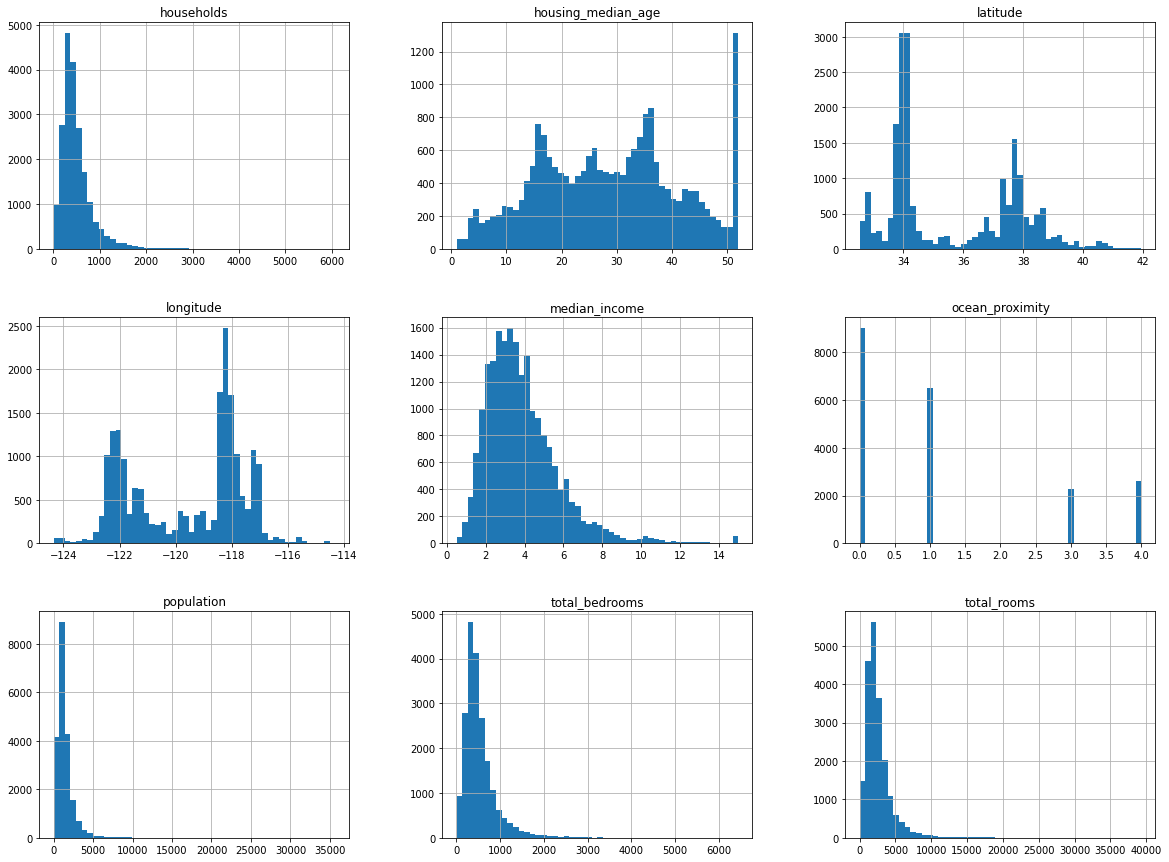

In [18]:
# Display histogram of features
df.hist(bins=50, figsize=(20, 15))

# Data Modeling

In [19]:
k_range = range(2, 11)

scaler_list = {StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler}
cluster_list = {
    KMeans: {
        'n_clusters': k_range,
        'init': ['k-means++', 'random'],
        'random_state': [1]
    },
    #clarans: {
    #    'number_clusters': k_range,
    #    'numlocal': [2, 4, 6],
    #    'maxneighbor': [3, 5, 7]
    #},
    DBSCAN: {
        'eps': [1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1],
        'min_samples': range(2, 6)
    },
    GaussianMixture: {
        'n_components': k_range,
        'random_state': [1]
    }
}
method_list = {'euclidean', 'manhattan'}

output = major_function(df, scaler=scaler_list, cluster=cluster_list, metric=method_list)
print(output)

[("None,<class 'sklearn.cluster._kmeans.KMeans'>,euclidean", <__main__.KMeansTune object at 0x7fab83d06ad0>), ("<class 'sklearn.preprocessing._data.MinMaxScaler'>,<class 'sklearn.cluster._kmeans.KMeans'>,euclidean", <__main__.KMeansTune object at 0x7fab83a3ac50>), ("<class 'sklearn.preprocessing._data.StandardScaler'>,<class 'sklearn.cluster._kmeans.KMeans'>,euclidean", <__main__.KMeansTune object at 0x7fab833e2ed0>), ("<class 'sklearn.preprocessing._data.RobustScaler'>,<class 'sklearn.cluster._kmeans.KMeans'>,euclidean", <__main__.KMeansTune object at 0x7fab839e4d50>), ("<class 'sklearn.preprocessing._data.MaxAbsScaler'>,<class 'sklearn.cluster._kmeans.KMeans'>,euclidean", <__main__.KMeansTune object at 0x7fab83341e90>), ("None,<class 'sklearn.cluster._dbscan.DBSCAN'>,euclidean", <__main__.DbscanTune object at 0x7fab834c7610>), ("<class 'sklearn.preprocessing._data.MinMaxScaler'>,<class 'sklearn.cluster._dbscan.DBSCAN'>,euclidean", <__main__.DbscanTune object at 0x7fab835aaf90>), ("<c

# Evaluation

In [20]:
for out in output:
  print(f'{out[0]}:{out[1].best_score_}')

None,<class 'sklearn.cluster._kmeans.KMeans'>,euclidean:0.7210040149782818
<class 'sklearn.preprocessing._data.MinMaxScaler'>,<class 'sklearn.cluster._kmeans.KMeans'>,euclidean:0.43256809655514894
<class 'sklearn.preprocessing._data.StandardScaler'>,<class 'sklearn.cluster._kmeans.KMeans'>,euclidean:0.3927036912683831
<class 'sklearn.preprocessing._data.RobustScaler'>,<class 'sklearn.cluster._kmeans.KMeans'>,euclidean:0.4916006200712294
<class 'sklearn.preprocessing._data.MaxAbsScaler'>,<class 'sklearn.cluster._kmeans.KMeans'>,euclidean:0.5359306775471181
None,<class 'sklearn.cluster._dbscan.DBSCAN'>,euclidean:-1.0
<class 'sklearn.preprocessing._data.MinMaxScaler'>,<class 'sklearn.cluster._dbscan.DBSCAN'>,euclidean:0.43175021469555946
<class 'sklearn.preprocessing._data.StandardScaler'>,<class 'sklearn.cluster._dbscan.DBSCAN'>,euclidean:-0.31547070581665454
<class 'sklearn.preprocessing._data.RobustScaler'>,<class 'sklearn.cluster._dbscan.DBSCAN'>,euclidean:-0.219237234612725
<class 's

In [27]:
for out in output:
  print(out[0])
  print(out[1])
  print(out[1].best_params_)
  print(out[1].best_model_)
  print(out[1].best_score_)
  print()

<class 'tuple'>
None,<class 'sklearn.cluster._kmeans.KMeans'>,euclidean
{'n_clusters': 2, 'init': 'k-means++', 'random_state': 1}
KMeans(n_clusters=2, random_state=1)
0.7210040149782818

<class 'tuple'>
<class 'sklearn.preprocessing._data.MinMaxScaler'>,<class 'sklearn.cluster._kmeans.KMeans'>,euclidean
{'n_clusters': 2, 'init': 'random', 'random_state': 1}
KMeans(init='random', n_clusters=2, random_state=1)
0.43256809655514894

<class 'tuple'>
<class 'sklearn.preprocessing._data.StandardScaler'>,<class 'sklearn.cluster._kmeans.KMeans'>,euclidean
{'n_clusters': 2, 'init': 'random', 'random_state': 1}
KMeans(init='random', n_clusters=2, random_state=1)
0.3927036912683831

<class 'tuple'>
<class 'sklearn.preprocessing._data.RobustScaler'>,<class 'sklearn.cluster._kmeans.KMeans'>,euclidean
{'n_clusters': 2, 'init': 'random', 'random_state': 1}
KMeans(init='random', n_clusters=2, random_state=1)
0.4916006200712294

<class 'tuple'>
<class 'sklearn.preprocessing._data.MaxAbsScaler'>,<class '

In [28]:
output.sort(key = lambda i:i[1].best_score_, reverse=True)
for out in output:
  print(out[0])
  print(out[1])
  print(out[1].best_params_)
  print(out[1].best_model_)
  print(out[1].best_score_)
  print()


<class 'tuple'>
<class 'sklearn.preprocessing._data.MaxAbsScaler'>,<class 'sklearn.cluster._dbscan.DBSCAN'>,manhattan
{'eps': 0.5, 'min_samples': 5}
DBSCAN()
0.7324134020001599

<class 'tuple'>
None,<class 'sklearn.cluster._kmeans.KMeans'>,euclidean
{'n_clusters': 2, 'init': 'k-means++', 'random_state': 1}
KMeans(n_clusters=2, random_state=1)
0.7210040149782818

<class 'tuple'>
None,<class 'sklearn.cluster._kmeans.KMeans'>,manhattan
{'n_clusters': 2, 'init': 'k-means++', 'random_state': 1}
KMeans(n_clusters=2, random_state=1)
0.7200988688041795

<class 'tuple'>
<class 'sklearn.preprocessing._data.MaxAbsScaler'>,<class 'sklearn.cluster._dbscan.DBSCAN'>,euclidean
{'eps': 0.5, 'min_samples': 5}
DBSCAN()
0.6549786048289512

<class 'tuple'>
<class 'sklearn.preprocessing._data.MaxAbsScaler'>,<class 'sklearn.cluster._kmeans.KMeans'>,euclidean
{'n_clusters': 2, 'init': 'random', 'random_state': 1}
KMeans(init='random', n_clusters=2, random_state=1)
0.5359306775471181

<class 'tuple'>
<class 's

# Creating cluster with median_house_value

In [92]:
def result_vs_cluster_with_median_house_value():
  df_with_median = df_src.copy()
  # Drop any with how=any
  df_with_median.dropna(how='any', inplace=True)
  df_with_median.reset_index(drop=True, inplace=True)
  n_df = df_with_median['median_house_value'].copy().sort_values()
  n_df.reset_index(drop=True,inplace=True)
  n = 20433
  q1 = int((0.3333 * (n + 1)) - 1)
  q2 = int((0.6666 * (n + 1)) - 1)
  df['target'] = np.nan
  print(q1)
  print(q2)
  print(n_df[q1])
  print(n_df[q2])
  df_with_median['target'] = np.nan
  df_with_median.loc[df_with_median['median_house_value'] < 141300, 'target'] = 'cheap'
  df_with_median.loc[df_with_median['target'] != ('cheap'), 'target'] = 'normal'
  df_with_median.loc[df_with_median['median_house_value'] > 230200, 'target'] = 'expensive'
  df_with_median.drop(['median_house_value'], axis=1, inplace=True)
  df_with_median['ocean_proximity'] = encoder.fit_transform(df_with_median['ocean_proximity'])
  df_with_median['target'] = encoder.fit_transform(df_with_median['target'])
  print(df_with_median['ocean_proximity'].value_counts())
  print(df_with_median['target'].value_counts())
  # 비주얼라이징만만 추가되면면 된다다..


In [93]:
result_vs_cluster_with_median_house_value()

6809
13620
141300.0
230200.0
0    9034
1    6496
4    2628
3    2270
2       5
Name: ocean_proximity, dtype: int64
2    6819
1    6812
0    6802
Name: target, dtype: int64
